# 2D Injector Optimization with NN Prior at LCLS
Aiming to optimize transverse beam size in 2D

In [1]:
import os
import socket

hostname = socket.gethostname()
if hostname == "lcls-srv04":
    os.environ["OMP_NUM_THREADS"] = str(1)
elif hostname == "test-rhel7":
    os.environ["OMP_NUM_THREADS"] = str(6)

In [2]:
# optionally add scripts location to path
if True:
    import sys
    sys.path.append("../../")
    sys.path.append("../")

run_dir = "/home/physics3/ml_tuning/20231120_LCLS_Injector/"
if not os.path.exists(run_dir):
    os.makedirs(run_dir)
print(sys.path)

['/home/physics/rroussel/SLAC_Xopt/lcls/nn_prior', '/usr/local/lcls/tools/python/toolbox', '/usr/local/lcls/package/anaconda/envs/python3.9envs/rhel7/nightly/11-17-2023/lib/python39.zip', '/usr/local/lcls/package/anaconda/envs/python3.9envs/rhel7/nightly/11-17-2023/lib/python3.9', '/usr/local/lcls/package/anaconda/envs/python3.9envs/rhel7/nightly/11-17-2023/lib/python3.9/lib-dynload', '', '/usr/local/lcls/package/anaconda/envs/python3.9envs/rhel7/nightly/11-17-2023/lib/python3.9/site-packages', '../../', '../']


## Define VOCS

In [3]:
import pandas as pd
from xopt import VOCS

In [4]:
filename = "../variables.csv"
VARIABLE_RANGES = pd.read_csv(filename, index_col=0, header=None).T.to_dict(orient='list')

In [5]:
VARIABLES = ["SOLN:IN20:121:BCTRL", "QUAD:IN20:121:BCTRL", "QUAD:IN20:122:BCTRL",
             "QUAD:IN20:361:BCTRL", "QUAD:IN20:371:BCTRL", "QUAD:IN20:425:BCTRL",
             "QUAD:IN20:441:BCTRL", "QUAD:IN20:511:BCTRL", "QUAD:IN20:525:BCTRL"]

vocs = VOCS(
    variables = {ele: VARIABLE_RANGES[ele] for ele in VARIABLES},
    constraints = {"bad_measurement": ["LESS_THAN", 0.5]},
    objectives = {"total_size": "MINIMIZE"},
)
print(vocs.as_yaml())

variables:
  SOLN:IN20:121:BCTRL: [0.377, 0.498]
  QUAD:IN20:121:BCTRL: [-0.021, 0.021]
  QUAD:IN20:122:BCTRL: [-0.021, 0.021]
  QUAD:IN20:361:BCTRL: [-4.32, -1.08]
  QUAD:IN20:371:BCTRL: [1.09, 4.31]
  QUAD:IN20:425:BCTRL: [-7.56, -1.08]
  QUAD:IN20:441:BCTRL: [-1.08, 7.56]
  QUAD:IN20:511:BCTRL: [-1.08, 7.56]
  QUAD:IN20:525:BCTRL: [-7.56, -1.08]
constraints:
  bad_measurement: [LESS_THAN, 0.5]
objectives: {total_size: MINIMIZE}
constants: {}
observables: []



## Define evaluate function

In [6]:
from time import sleep

import torch
import numpy as np
from epics import caput, caget_many, caget

from utils import get_model_predictions, numpy_save

In [9]:
objective_scale = 1e-3

In [11]:
from time import sleep
from epics import caget


def eval_beamsize(input_dict, generator = None):
    # global image_diagnostic
    # set PVs
    for k, v in input_dict.items():
        print(f'CAPUT {k} {v}')
        caput(k, v)

    # sleep(5.0)

    # # get beam sizes from image diagnostic
    # metadata = input_dict
    # results = image_diagnostic.measure_beamsize(1, **metadata)
    # results["S_x_mm"] = np.array(results["Sx"]) * 1e-3
    # results["S_y_mm"] = np.array(results["Sy"]) * 1e-3
    
    input_str = input()
    results = {}
    if input_str == "0":
        results["Sx"] = np.nan
        results["Sy"] = np.nan
        results["bad_measurement"] = 1.0
    else:
        results["Sx"] = caget("WIRE:IN20:561:XRMS")  # in micrometer
        results["Sy"] = caget("WIRE:IN20:561:YRMS")  # in micrometer
        results["bad_measurement"] = 0.0

    # get other PV's NOTE: Measurements not synchronous with beamsize measurements!
    results = results

    # add total beam size
    sigma_xy = np.sqrt(np.array(results["Sx"]) ** 2 + np.array(results["Sy"]) ** 2)
    roundness = np.abs(np.array(results["Sx"]) - np.array(results["Sy"]))
    results["sigma_xy"] = sigma_xy
    results["total_size"] = objective_scale * (sigma_xy + roundness)    
    # results["total_size"] = np.sqrt(np.abs(np.array(results["Sx"])) * np.array(results["Sy"]))
    
    # GP model predictions
    model_predictions = get_model_predictions(input_dict, generator)
    results.update(model_predictions)

    # numpy_save()
    
    return results

## Define NN prior

In [13]:
from lume_model.utils import variables_from_yaml
from lume_model.models import TorchModel, TorchModule

sys.path.append("calibration/calibration_modules/")
from decoupled_linear import OutputOffset, OutputScale, DecoupledLinearOutput

In [14]:
model_path = "lcls_cu_injector_nn_model/"

# # load nn_to_cal transformers
# reg = "low"  # "low" or "high"
# input_nn_to_cal = torch.load(f"calibration/input_nn_to_cal_{reg}_reg.pt")
# output_nn_to_cal = torch.load(f"calibration/output_nn_to_cal_{reg}_reg.pt")

# load sim_to_nn transformers
input_sim_to_nn = torch.load(model_path + "model/input_sim_to_nn.pt")
output_sim_to_nn = torch.load(model_path + "model/output_sim_to_nn.pt")

# load pv_to_sim transformers
input_pv_to_sim = torch.load(model_path + "model/input_pv_to_sim.pt")
output_pv_to_sim = torch.load(model_path + "model/output_pv_to_sim.pt")

# load in- and output variable specification
input_variables, output_variables = variables_from_yaml(model_path + "model/pv_variables.yml")
# input_variables, output_variables = variables_from_yaml(f"calibration/pv_variables_{reg}_reg_pydantic2.yml")

# replace keys in input variables
for var in input_variables:
    var.name = var.name.replace("BACT", "BCTRL")

# create TorchModel
lume_model = TorchModel(
    model=model_path + "model/model.pt",
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_pv_to_sim, input_sim_to_nn],
    output_transformers=[output_sim_to_nn, output_pv_to_sim],
    # input_transformers=[input_pv_to_sim, input_sim_to_nn, input_nn_to_cal],
    # output_transformers=[output_nn_to_cal, output_sim_to_nn, output_pv_to_sim],
)

# wrap in TorchModule
lume_module = TorchModule(
    model=lume_model,
    input_order=vocs.variable_names,
    output_order=lume_model.output_names[0:2],
)

# define objective model
class ObjectiveModel(torch.nn.Module):
    def __init__(self, model: TorchModule):
        super(ObjectiveModel, self).__init__()
        self.model = model

    @staticmethod
    def function(sigma_x: torch.Tensor, sigma_y: torch.Tensor) -> torch.Tensor:
        # using this calculation due to occasional negative values
        sigma_xy = torch.sqrt(sigma_x ** 2 + sigma_y ** 2)
        roundness = torch.abs(sigma_x - sigma_y)
        return (sigma_xy + roundness) * objective_scale

    def forward(self, x) -> torch.Tensor:
        idx_sigma_x = self.model.output_order.index("OTRS:IN20:571:XRMS")
        idx_sigma_y = self.model.output_order.index("OTRS:IN20:571:YRMS")
        sigma_x = self.model(x)[..., idx_sigma_x]
        sigma_y = self.model(x)[..., idx_sigma_y]
        return self.function(sigma_x, sigma_y)


objective_model = ObjectiveModel(lume_module)

In [15]:
# define custom mean
objective_model.requires_grad_(False);

custom_mean = objective_model
# custom_mean = OutputOffset(
#     model=objective_model,
# )

## Restrict ranges based on profile monitor

In [16]:
vocs.variables = {k: input_variables[lume_model.input_names.index(k)].value_range for k in vocs.variable_names}
vocs.variables["SOLN:IN20:121:BCTRL"] = [0.467, 0.479]
print(vocs.as_yaml())

variables:
  QUAD:IN20:121:BCTRL: [-0.02098429469554406, 0.020999198106589838]
  QUAD:IN20:122:BCTRL: [-0.020998830517503037, 0.020998929132148195]
  QUAD:IN20:361:BCTRL: [-4.318053641915576, -1.0800430432494976]
  QUAD:IN20:371:BCTRL: [1.0913525514575348, 4.30967984810423]
  QUAD:IN20:425:BCTRL: [-7.559759590824369, -1.080762695815712]
  QUAD:IN20:441:BCTRL: [-1.0782202690353522, 7.559878303179915]
  QUAD:IN20:511:BCTRL: [-1.0792451325247663, 7.5582919025608595]
  QUAD:IN20:525:BCTRL: [-7.557932980106783, -1.0800286565992732]
  SOLN:IN20:121:BCTRL: [0.467, 0.479]
constraints:
  bad_measurement: [LESS_THAN, 0.5]
objectives: {total_size: MINIMIZE}
constants: {}
observables: []



## Run Xopt

In [17]:
from xopt import Xopt, VOCS
from xopt.evaluator import Evaluator
from xopt.numerical_optimizer import LBFGSOptimizer
from xopt.generators.bayesian import ExpectedImprovementGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor

# remember to set use low noise prior to false!!!
gp_constructor = StandardModelConstructor(
    use_low_noise_prior=False,
    mean_modules={"total_size": custom_mean},
    trainable_mean_keys=["total_size"],
)
generator = ExpectedImprovementGenerator(
    vocs=vocs,
    gp_constructor=gp_constructor,
)
generator.numerical_optimizer.max_iter = 200
evaluator = Evaluator(function=eval_beamsize, function_kwargs={"generator": generator})
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
X.evaluator = Evaluator(function=eval_beamsize, function_kwargs={"generator": X.generator})
X.dump_file = run_dir + "nn_optimization_9d_1.yml"
X


            Xopt
________________________________
Version: 2.1.0+6.gb4fe9a1
Data size: 0
Config as YAML:
dump_file: /home/physics3/ml_tuning/20231117_LCLS_Injector/nn_optimization_9d_1.yml
evaluator:
  function: __main__.eval_beamsize
  function_kwargs:
    generator:
      computation_time: null
      fixed_features: null
      gp_constructor:
        covar_modules: {}
        mean_modules: {}
        name: standard
        trainable_mean_keys:
        - total_size
        use_low_noise_prior: false
      log_transform_acquisition_function: false
      max_travel_distances: null
      model: null
      n_candidates: 1
      n_monte_carlo_samples: 128
      numerical_optimizer:
        max_iter: 200
        max_time: null
        n_restarts: 20
        name: LBFGS
      supports_batch_generation: true
      turbo_controller: null
      use_cuda: false
  max_workers: 1
  vectorized: false
generator:
  computation_time: null
  fixed_features: null
  gp_constructor:
    covar_modules: {}

In [18]:
from xopt.utils import get_local_region

# get current point
current_value = {'SOLN:IN20:121:BCTRL': 0.4811964507056114,
 'QUAD:IN20:121:BCTRL': 0.00066783437,
 'QUAD:IN20:122:BCTRL': -0.008649478074999996,
 'QUAD:IN20:361:BCTRL': -3.3494902000000004,
 'QUAD:IN20:371:BCTRL': 2.6127829,
 'QUAD:IN20:425:BCTRL': -1.0063387,
 'QUAD:IN20:441:BCTRL': -0.2840484,
 'QUAD:IN20:511:BCTRL': 3.2541227,
 'QUAD:IN20:525:BCTRL': -2.7533598
}

# get small region around current point to sample
random_sample_region = get_local_region(current_value, X.vocs, fraction=0.1)

# random sample in a local region
X.random_evaluate(5, custom_bounds=random_sample_region)

CAPUT QUAD:IN20:121:BCTRL 0.001491122802780123
CAPUT QUAD:IN20:122:BCTRL -0.009669420653899691
CAPUT QUAD:IN20:361:BCTRL -3.1330458663969254
CAPUT QUAD:IN20:371:BCTRL 2.494480090078397
CAPUT QUAD:IN20:425:BCTRL -1.229420251500529
CAPUT QUAD:IN20:441:BCTRL -0.44010171425875877
CAPUT QUAD:IN20:511:BCTRL 3.9530509197815658
CAPUT QUAD:IN20:525:BCTRL -3.3057518148066687
CAPUT SOLN:IN20:121:BCTRL 0.479


 1


CAPUT QUAD:IN20:121:BCTRL -0.0034943563654254764
CAPUT QUAD:IN20:122:BCTRL -0.012781407709246531
CAPUT QUAD:IN20:361:BCTRL -3.421660782301584
CAPUT QUAD:IN20:371:BCTRL 2.917579182326721
CAPUT QUAD:IN20:425:BCTRL -1.1595115576843882
CAPUT QUAD:IN20:441:BCTRL -0.8516468332481204
CAPUT QUAD:IN20:511:BCTRL 3.6695201729481206
CAPUT QUAD:IN20:525:BCTRL -2.61158506962792
CAPUT SOLN:IN20:121:BCTRL 0.479


 1


CAPUT QUAD:IN20:121:BCTRL -0.0016094617193106425
CAPUT QUAD:IN20:122:BCTRL -0.004700280374111592
CAPUT QUAD:IN20:361:BCTRL -3.101068570948206
CAPUT QUAD:IN20:371:BCTRL 2.799969425548643
CAPUT QUAD:IN20:425:BCTRL -1.5315267917384854
CAPUT QUAD:IN20:441:BCTRL 0.4138212518417671
CAPUT QUAD:IN20:511:BCTRL 3.0705826144653594
CAPUT QUAD:IN20:525:BCTRL -2.322330691307872
CAPUT SOLN:IN20:121:BCTRL 0.479


 1


CAPUT QUAD:IN20:121:BCTRL 0.004612997604682451
CAPUT QUAD:IN20:122:BCTRL -0.010166096277408736
CAPUT QUAD:IN20:361:BCTRL -3.2342234413610793
CAPUT QUAD:IN20:371:BCTRL 2.599345964166094
CAPUT QUAD:IN20:425:BCTRL -1.6272640574688189
CAPUT QUAD:IN20:441:BCTRL -1.0390567424630308
CAPUT QUAD:IN20:511:BCTRL 2.5875837647228725
CAPUT QUAD:IN20:525:BCTRL -3.135550151109924
CAPUT SOLN:IN20:121:BCTRL 0.479


 1


CAPUT QUAD:IN20:121:BCTRL -0.002771886622015007
CAPUT QUAD:IN20:122:BCTRL -0.010901753152217402
CAPUT QUAD:IN20:361:BCTRL -3.503321608369331
CAPUT QUAD:IN20:371:BCTRL 2.553589695646995
CAPUT QUAD:IN20:425:BCTRL -1.1977362886614964
CAPUT QUAD:IN20:441:BCTRL -0.6808805963390623
CAPUT QUAD:IN20:511:BCTRL 2.9956120971937854
CAPUT QUAD:IN20:525:BCTRL -2.7014800183980676
CAPUT SOLN:IN20:121:BCTRL 0.479


 1


,QUAD:IN20:121:BCTRL,QUAD:IN20:122:BCTRL,QUAD:IN20:361:BCTRL,QUAD:IN20:371:BCTRL,QUAD:IN20:425:BCTRL,QUAD:IN20:441:BCTRL,QUAD:IN20:511:BCTRL,QUAD:IN20:525:BCTRL,SOLN:IN20:121:BCTRL,Sx,...,sigma_xy,total_size,total_size_prior_mean,total_size_posterior_mean,total_size_posterior_sd,bad_measurement_prior_mean,bad_measurement_posterior_mean,bad_measurement_posterior_sd,xopt_runtime,xopt_error
0,0.001491,-0.009669,-3.133046,2.494480,-1.229420,-0.440102,3.953051,-3.305752,0.479,0.000043,...,0.000107,1.633414e-07,NaN,NaN,NaN,NaN,NaN,NaN,51.753755,False
1,-0.003494,-0.012781,-3.421661,2.917579,-1.159512,-0.851647,3.669520,-2.611585,0.479,0.000100,...,0.000163,1.920320e-07,NaN,NaN,NaN,NaN,NaN,NaN,26.691138,False
2,-0.001609,-0.004700,-3.101069,2.799969,-1.531527,0.413821,3.070583,-2.322331,0.479,0.000163,...,0.000224,2.331111e-07,NaN,NaN,NaN,NaN,NaN,NaN,34.373869,False
3,0.004613,-0.010166,-3.234223,2.599346,-1.627264,-1.039057,2.587584,-3.135550,0.479,0.000211,...,0.000240,3.372625e-07,NaN,NaN,NaN,NaN,NaN,NaN,50.847615,False
4,-0.002772,-0.010902,-3.503322,2.553590,-1.197736,-0.680881,2.995612,-2.701480,0.479,0.000122,...,0.000139,1.958441e-07,NaN,NaN,NaN,NaN,NaN,NaN,40.709359,False


In [19]:
X.data.keys()

Index(['QUAD:IN20:121:BCTRL', 'QUAD:IN20:122:BCTRL', 'QUAD:IN20:361:BCTRL',
       'QUAD:IN20:371:BCTRL', 'QUAD:IN20:425:BCTRL', 'QUAD:IN20:441:BCTRL',
       'QUAD:IN20:511:BCTRL', 'QUAD:IN20:525:BCTRL', 'SOLN:IN20:121:BCTRL',
       'Sx', 'Sy', 'bad_measurement', 'sigma_xy', 'total_size',
       'total_size_prior_mean', 'total_size_posterior_mean',
       'total_size_posterior_sd', 'bad_measurement_prior_mean',
       'bad_measurement_posterior_mean', 'bad_measurement_posterior_sd',
       'xopt_runtime', 'xopt_error'],
      dtype='object')

In [22]:
n_init = 10
initial_data_file = os.path.join(run_dir, f"optimization_9d_initial_data_n={n_init}.csv")

if os.path.isfile(initial_data_file):
    initial_data = pd.read_csv(initial_data_file)
    X.add_data(initial_data)
else:
    X.random_evaluate(n_init)
    X.data.to_csv(initial_data_file, index=False)

X.data

CAPUT QUAD:IN20:121:BCTRL -0.017980356583352522
CAPUT QUAD:IN20:122:BCTRL -0.02079727297502174
CAPUT QUAD:IN20:361:BCTRL -3.27483851477981
CAPUT QUAD:IN20:371:BCTRL 2.712470492327434
CAPUT QUAD:IN20:425:BCTRL -4.453715448152963
CAPUT QUAD:IN20:441:BCTRL 5.538904994748951
CAPUT QUAD:IN20:511:BCTRL 6.045144527392791
CAPUT QUAD:IN20:525:BCTRL -5.336652182989161
CAPUT SOLN:IN20:121:BCTRL 0.47524178312394216


CAPUT QUAD:IN20:121:BCTRL 0.0011336086827636368
CAPUT QUAD:IN20:122:BCTRL -0.0012715812105641277
CAPUT QUAD:IN20:361:BCTRL -3.355893276619567
CAPUT QUAD:IN20:371:BCTRL 1.7961798081516958
CAPUT QUAD:IN20:425:BCTRL -3.6982749679637426
CAPUT QUAD:IN20:441:BCTRL 0.9788019208376055
CAPUT QUAD:IN20:511:BCTRL 0.36653703335949794
CAPUT QUAD:IN20:525:BCTRL -1.522867669087575
CAPUT SOLN:IN20:121:BCTRL 0.4749728060410773


UnboundLocalError: local variable 'result' referenced before assignment

In [21]:
%%time
for i in range(10):
    print(i)
    X.step()

0


/usr/local/lcls/package/anaconda/envs/python3.9envs/rhel7/nightly/11-17-2023/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/usr/local/lcls/package/anaconda/envs/python3.9envs/rhel7/nightly/11-17-2023/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/usr/local/lcls/package/anaconda/envs/python3.9envs/rhel7/nightly/11-17-2023/lib/python3.9/site-packages/botorch/optim/fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/usr/local/lcls/package/anaconda/envs/python3.9envs/rhel7/nightly/11-17-2023/lib/python3.9/site-packages/botorch/optim

ModelFittingError: All attempts to fit the model have failed. For more information, try enabling botorch.settings.debug mode.

<Axes: >

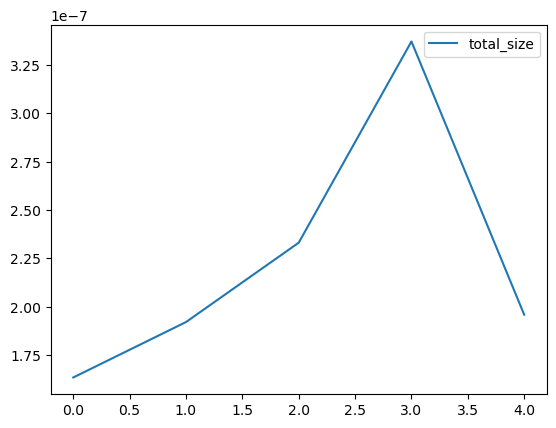

In [20]:
X.data.plot(y="total_size")

In [ ]:
X.data.plot(y=X.vocs.variable_names)

In [ ]:
X.generator.computation_time[["training", "acquisition_optimization"]].plot();

In [ ]:
# running minimum
running_min = []
for i in range(len(X.data)):
    running_min.append(X.data[vocs.objective_names[0]].iloc[:i+1].min())

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(X.data.index.values, X.data[vocs.objective_names[0]].values, label="BO Sequence")
ax.plot(X.data.index.values, running_min, label="Running Minimum")
ax.set_ylabel(f"{vocs.objective_names[0]}")
ax.legend()
fig.tight_layout()

## Display GP model predictions

In [ ]:
X.data[["total_size" + k for k in ["", "_prior_mean", "_posterior_mean", "_posterior_sd"]]].plot();

In [ ]:
X.generator.visualize_model(
    variable_names=["SOLN:IN20:121:BCTRL"],
    show_prior_mean=True,
    show_feasibility=True,
);